### Import the required libraries

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn import metrics

from xgboost import XGBRegressor
from xgboost import plot_importance
import warnings
from warnings import filterwarnings
filterwarnings("ignore")

### Read the files and check the first few rows

In [3]:
calories =  pd.read_csv("calories.csv")
exercise =  pd.read_csv("exercise.csv")

In [4]:
calories.head()

,User_ID,Calories
0,14733363,231.0
1,14861698,66.0
2,11179863,26.0
3,16180408,71.0
4,17771927,35.0


In [5]:
exercise.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8


### Combine the two datasets

In [6]:
data = pd.concat([exercise,calories["Calories"]],axis=1)

### Conduct some preliminary EDA by checking the datatypes and null values and duplicated values

In [7]:
data.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   User_ID     15000 non-null  int64  
 1   Gender      15000 non-null  object 
 2   Age         15000 non-null  int64  
 3   Height      15000 non-null  float64
 4   Weight      15000 non-null  float64
 5   Duration    15000 non-null  float64
 6   Heart_Rate  15000 non-null  float64
 7   Body_Temp   15000 non-null  float64
 8   Calories    15000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 1.0+ MB


In [9]:
data.describe()

,User_ID,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,1.497736e+07,42.789800,174.465133,74.966867,15.530600,95.518533,40.025453,89.539533
std,2.872851e+06,16.980264,14.258114,15.035657,8.319203,9.583328,0.779230,62.456978
min,1.000116e+07,20.000000,123.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,1.247419e+07,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,35.000000
50%,1.499728e+07,39.000000,175.000000,74.000000,16.000000,96.000000,40.200000,79.000000
75%,1.744928e+07,56.000000,185.000000,87.000000,23.000000,103.000000,40.600000,138.000000
max,1.999965e+07,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


In [10]:
data.isna().sum()

User_ID       0
Gender        0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64

In [11]:
data.duplicated().sum()

0

### Remove the User_ID column because of its irrelavancy

In [12]:
data.drop(columns=["User_ID"],axis=1,inplace=True)

In [13]:
data.head()

,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,female,20,166.0,60.0,14.0,94.0,40.3,66.0
2,male,69,179.0,79.0,5.0,88.0,38.7,26.0
3,female,34,179.0,71.0,13.0,100.0,40.5,71.0
4,female,27,154.0,58.0,10.0,81.0,39.8,35.0


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Gender      15000 non-null  object 
 1   Age         15000 non-null  int64  
 2   Height      15000 non-null  float64
 3   Weight      15000 non-null  float64
 4   Duration    15000 non-null  float64
 5   Heart_Rate  15000 non-null  float64
 6   Body_Temp   15000 non-null  float64
 7   Calories    15000 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 937.6+ KB


### There  is one categorical variable and it has to be converted to dummies

In [15]:
data =  pd.get_dummies(data, drop_first=True)

In [16]:
data.head()

,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Gender_male
0,68,190.0,94.0,29.0,105.0,40.8,231.0,True
1,20,166.0,60.0,14.0,94.0,40.3,66.0,False
2,69,179.0,79.0,5.0,88.0,38.7,26.0,True
3,34,179.0,71.0,13.0,100.0,40.5,71.0,False
4,27,154.0,58.0,10.0,81.0,39.8,35.0,False


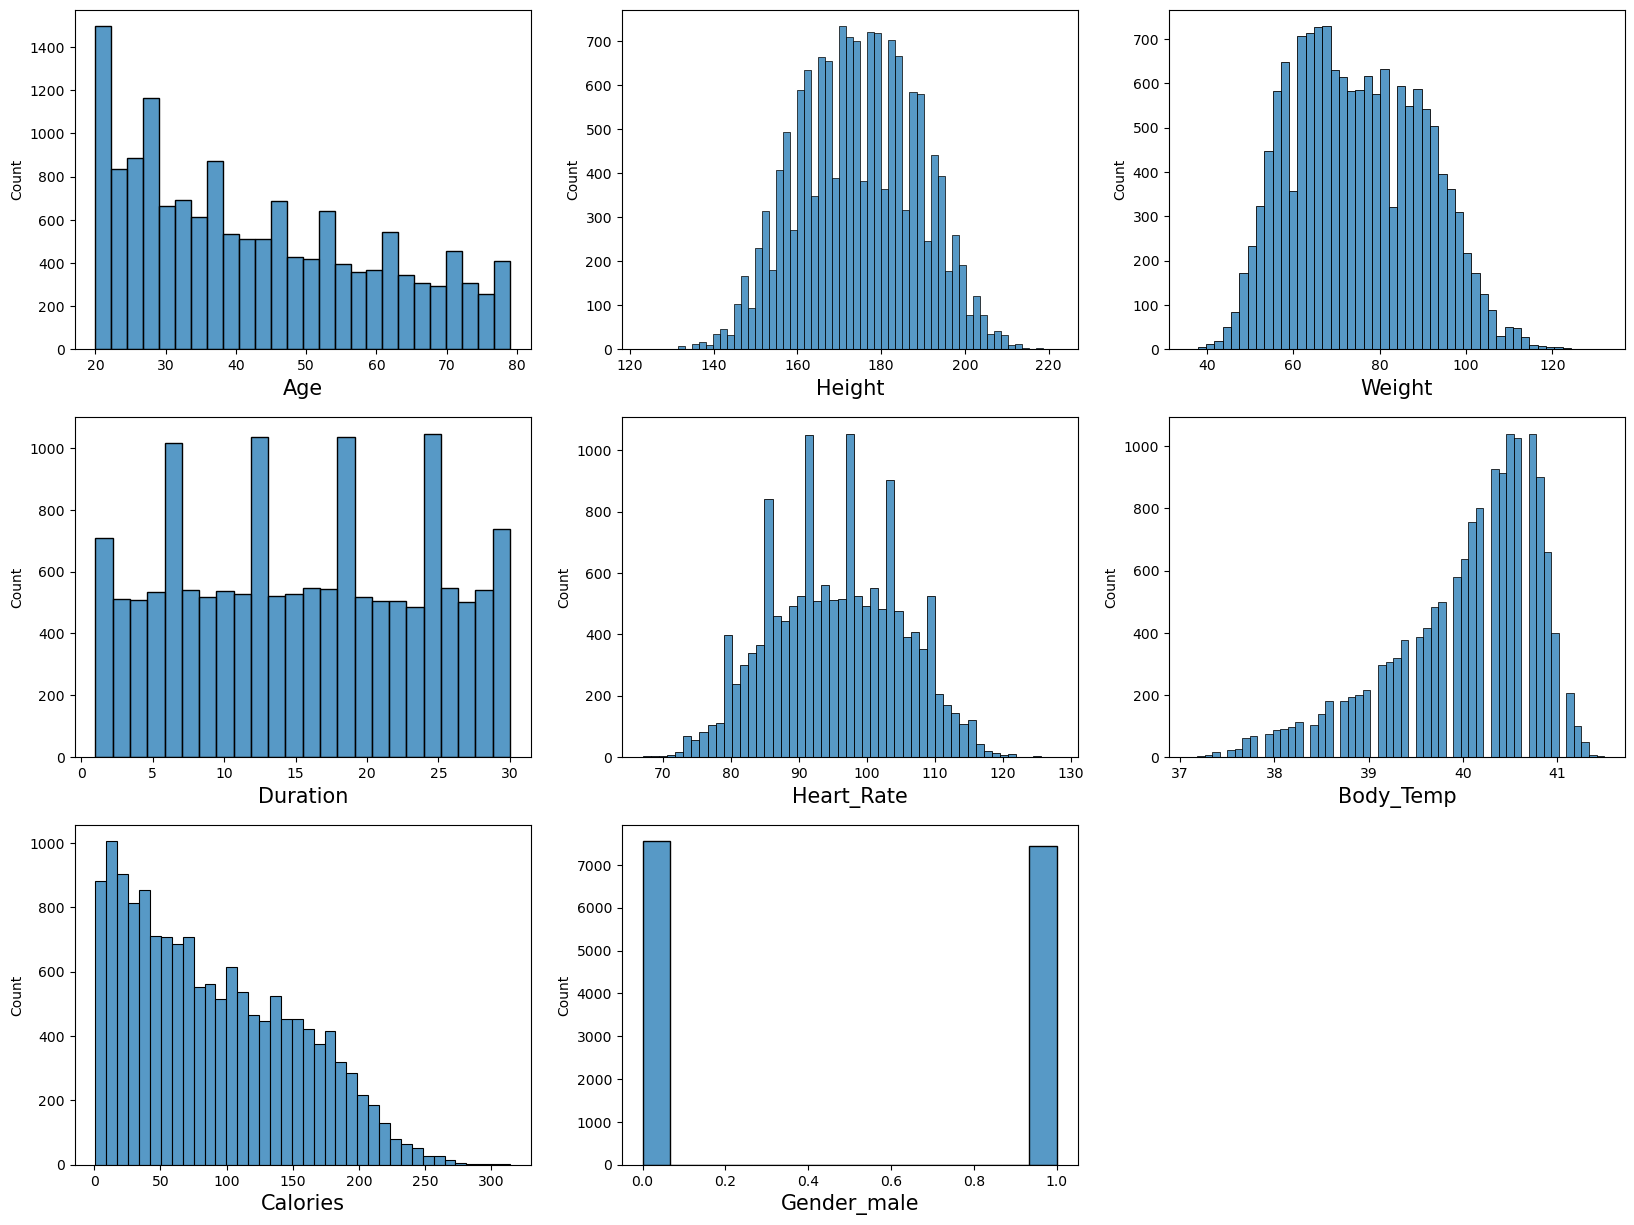

In [17]:
plt.figure(figsize=(20,15))
plotnumber = 1

for column in data:
  if plotnumber <= 8:
    ax = plt.subplot(3,3,plotnumber)
    sns.histplot(data[column])
    plt.xlabel(column,fontsize=15)
  plotnumber+=1
plt.show()

### Check the heatmap to understand correlation

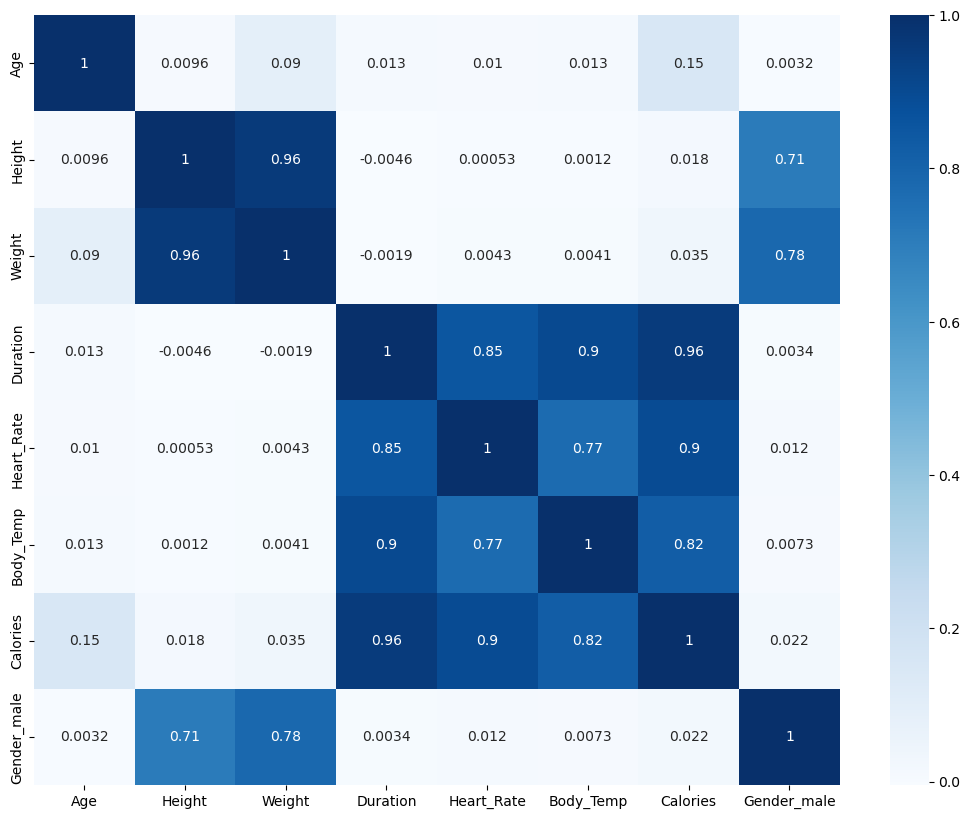

In [18]:
plt.figure(figsize=(13,10))
sns.heatmap(data.corr(), cmap='Blues',annot = True)
plt.show()

### Divide the dataset as target variable and the independent variables

In [19]:
X = data.drop(columns=["Calories"],axis=1)
y = data["Calories"]

In [20]:
X.head()

,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Gender_male
0,68,190.0,94.0,29.0,105.0,40.8,True
1,20,166.0,60.0,14.0,94.0,40.3,False
2,69,179.0,79.0,5.0,88.0,38.7,True
3,34,179.0,71.0,13.0,100.0,40.5,False
4,27,154.0,58.0,10.0,81.0,39.8,False


In [21]:
y.head()

0    231.0
1     66.0
2     26.0
3     71.0
4     35.0
Name: Calories, dtype: float64

### Split the data into test and train set

In [22]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25, random_state=0)

### Conduct hyperparameter tuning to get the best estimator

In [23]:
xgb = XGBRegressor()
cv_param = {'max_depth' : [2,4,None],
           'max_features': [0.3,0.6,1.0],'max_samples': [0.7],
           'min_samples_leaf' : [1,2],
           'min_samples_split' : [2,3],
            'n_estimators' : [75,100,125]}

xgb_cv = GridSearchCV(xgb, cv_param, scoring="r2", cv= 5)

Fit the  model into the train data

In [24]:
%%time
xgb_cv.fit(X_train,y_train)

CPU times: total: 6min 49s
Wall time: 35.8 s


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'max_depth': [2, 4, None],
                         'max_features': [0.3, 0.6, 1.0], 'max_samples': [0.7],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [75, 100, 125]},
             scoring='r2')

In [25]:
y_pred = xgb_cv.predict(X_test)

In [26]:
xgb_cv.best_params_

{'max_depth': None,
 'max_features': 0.3,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 125}

In [27]:
print('r^2 score: ',metrics.r2_score(y_test,y_pred))

print('Mean Absolute Error:',metrics.mean_absolute_error(y_test,y_pred))
print('Mean Square Error:',metrics.mean_squared_error(y_test,y_pred))
print('Root Mean Square Error:',np.sqrt(metrics.mean_squared_error(y_test,y_pred)))

r^2 score:  0.9988408581246289
Mean Absolute Error: 1.4799178781032563
Mean Square Error: 4.422052242559593
Root Mean Square Error: 2.1028676236414867


### Check the feature importances of the independent variables

In [28]:
cdf = pd.DataFrame(xgb_cv.best_estimator_.feature_importances_, X.columns, columns=['Coefficients'])
print(cdf)

             Coefficients
Age              0.019960
Height           0.000427
Weight           0.004863
Duration         0.896790
Heart_Rate       0.048065
Body_Temp        0.000177
Gender_male      0.029718


<Axes: >

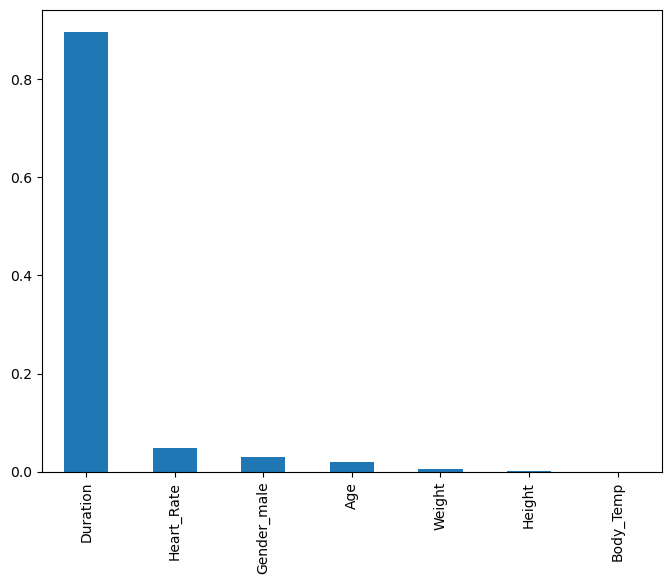

In [29]:
importance =  xgb_cv.best_estimator_.feature_importances_
xg_importance = pd.Series(importance, index= X_test.columns)
xg_importance = xg_importance.sort_values(ascending=False)

fig,ax =  plt.subplots(figsize=(8,6))
xg_importance.plot.bar(ax=ax)

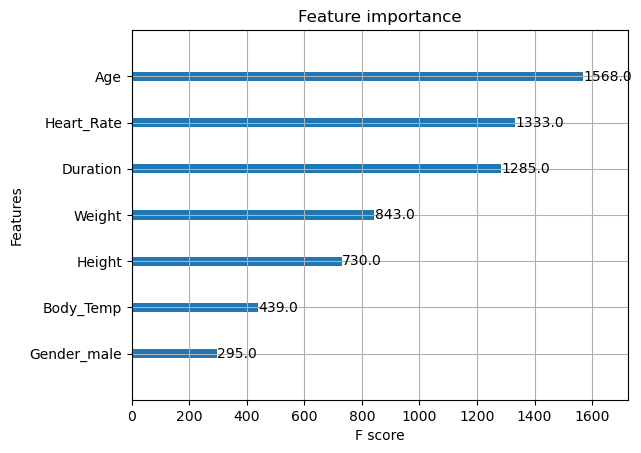

In [30]:
plot_importance(xgb_cv.best_estimator_, max_num_features = 15)
plt.show()